In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect = True)


In [17]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table

measurement = Base.classes.measurement

station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [24]:
# To view the columns
print("...Measurement...")
m_col = inspector.get_columns('measurement')
for column in m_col:
    print(column["name"], column["type"])
print("...Station...")
s_col = inspector.get_columns('station')
for c in s_col:
     print(c["name"], c["type"])

...Measurement...
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
...Station...
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [31]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

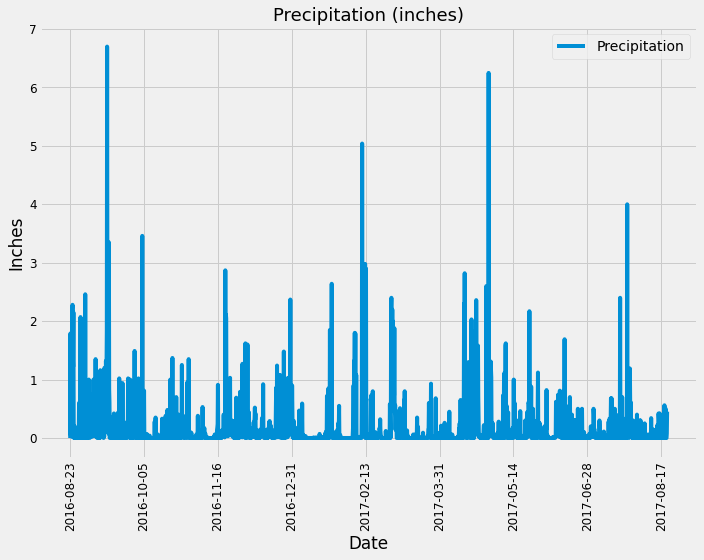

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# converting to date format
last_dt = (dt.datetime.strptime(recent_date, "%Y-%m-%d")).date()
last_dt

# Calculate the date one year from the last date in data set.

oneyearago = last_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date, measurement.prcp).\
                filter((measurement.date >= oneyearago)\
                & (measurement.date <= last_dt)).all()

# Save the query results as a Pandas DataFrame,set the index to the date column & Sort the dataframe by date

precipitation_df = pd.DataFrame(precipitation, columns=["Date", "Precipitation"]).sort_values("Date").set_index("Date")

#dropping null values
precipitation_df.dropna(axis=0, how="any", inplace=True)
precipitation_df.head()


# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(figsize=(10,8), fontsize=12, rot=90)
plt.title(f"Precipitation (inches)", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Inches")

plt.tight_layout()
plt.savefig("Precipitation.png")
plt.show()


In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [51]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(station).count()
print(f"There are {total_station} stations in the dataset.\n")


There are 9 stations in the dataset.



In [52]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  order_by(func.count(measurement.station).desc()).\
                  group_by(measurement.station).\
                  all()

# --- display the active stations ---
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
print (f"Most active station is {most_active_station}.")

# --- To calculate lowest temp 
low_temp = session.query(func.min(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()
              
print(f"Lowest temperature: {low_temp} degrees Fahrenheit")

# --- To calculate highest temp 
high_temp = session.query(func.max(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Highest temperature: {high_temp} degrees Fahrenheit")

# --- To calculate average temp 
avg_temp = session.query(func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).scalar()

print(f"Average temperature: {round(avg_temp)} degrees Fahrenheit")

Most active station is USC00519281.
Lowest temperature: 54.0 degrees Fahrenheit
Highest temperature: 85.0 degrees Fahrenheit
Average temperature: 72 degrees Fahrenheit


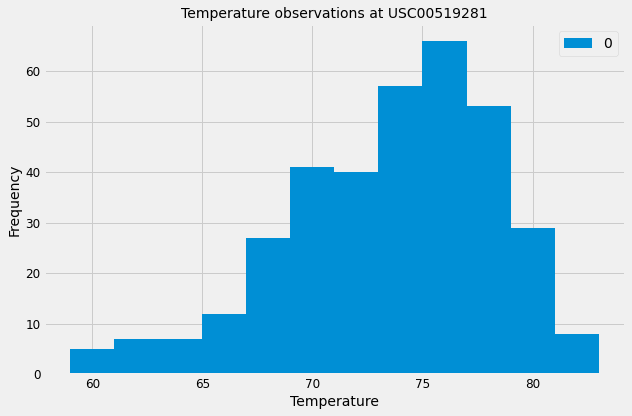

In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_tob = pd.DataFrame(session.query(measurement.tobs).\
                                filter((measurement.station == most_active_station)\
                                        & (measurement.date >= oneyearago)\
                                        & (measurement.date <= last_dt)).all())

most_active_tob.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations at {most_active_station}", fontsize=14)

plt.tight_layout()
plt.savefig("hist.png")
plt.show()


# Close session

In [57]:
# Close Session
session.close()